In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

In [ ]:
#ADD SUPPORT POINTS!

In [2]:
import os
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm

import matplotlib.pyplot as plt
import multiprocessing as mp

pd.set_option('display.max_rows', 100)

store_stocks_dict = dict()
store_indexes_dict = dict()

## Loading and utils

In [80]:
def update_stocks():
    os.system("rm mstcgl*.zip")
    #os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/ciagle/mstock/mstcgl.zip")
    os.system("rm -rf data/*")
    os.system("unzip mstcgl.zip -d data/")
    
    print(f'Updated {date.today()}, max actual date: \
    {prepare_data("WIG20").index.max().strftime(format = "%Y-%m-%d")}')
    
def update_indexes():
    os.system("rm mstzgr*.zip")
    #os.system("rm mstzgr.zip -d data_for/")
    os.system("wget https://moja.info.bossa.pl/pub/indzagr/mstock/mstzgr.zip")
    os.system("rm -rf data_for/*")
    os.system("unzip mstzgr.zip -d data_for/")
    
    print(f'Updated {date.today()}, max actual date: \
    {prepare_index("NIKKEI").index.max().strftime(format = "%Y-%m-%d")}')
    
def prepare_data(paper):
        
    if 'mst' in paper:
        paper = str(paper).rstrip('.mst')

    try:
        df = store_stocks_dict[paper].copy()
    except:
        df = pd.read_csv(f'data/{paper}.mst') 

        df.columns = [str(c).replace('<','') for c in df.columns]
        df.columns = [str(c).replace('>','') for c in df.columns]

        df.loc[:,'DTYYYYMMDD'] = pd.to_datetime(df.loc[:,'DTYYYYMMDD'], format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_stocks_dict[paper] = df.copy()
    
    return df

def prepare_index(indeks):
    
    if 'mst' in indeks:
        indeks = str(indeks).rstrip('.mst')
       
    try:
        df = store_indexes_dict[indeks].copy()
    except:
        df = pd.read_csv(f'data_for/{indeks}.mst') 

        df.columns = [str(c).replace('<','') for c in df.columns]
        df.columns = [str(c).replace('>','') for c in df.columns]

        df.loc[:,'DTYYYYMMDD'] = pd.to_datetime(df.loc[:,'DTYYYYMMDD'], format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_indexes_dict[indeks] = df.copy()
    
    return df

In [39]:
update_indexes()

Updated 2020-04-11, max actual date:     2020-04-10


In [40]:
update_stocks()

Updated 2020-04-11, max actual date:     2020-04-09


In [15]:
all_stocks = os.listdir('data/')
all_indekses = os.listdir('data_for/')
print(f'no of all available stock: {len(all_stocks)} and indexes: {len(all_indekses)}')

no of all available stock: 1957 and indexes: 23


## Single plot

In [43]:
before_crises = '2020-02-15'
big_drop_date = '2020-03-12'
today = str(date.today())

In [47]:
def plot_paper(papier, plot_range_min, plot_range_max):
    df = prepare_data(papier)

    plot_df = df.loc[(df.index >= plot_range_min) & 
                     (df.index <= plot_range_max),:].copy()
    if not plot_df.shape[0]:
        return 'Nothing to show!'

    spread = (plot_df.loc[:,'CLOSE'].max() - plot_df.loc[:,'CLOSE'].min()) / 14

    plot_df.loc[:,'CLOSE_diff'] = ((plot_df.loc[:,'CLOSE']
                                                - plot_df.loc[:,'CLOSE'].shift(1))
                                                / plot_df.loc[:,'CLOSE'].shift(1)) * 100

    plot_df_bar = ((plot_df.loc[:,'VOL'] - plot_df.loc[:,'VOL'].mean()) 
               / plot_df.loc[:,'VOL'].std() * spread)
    plot_df_bar = plot_df_bar + abs(plot_df_bar.min())
    plot_bar_bottom = plot_df.loc[:,'CLOSE'].min() - plot_df_bar.max()

    plot_df_vol_close = (plot_df.loc[:,'VOL'].rolling(3).mean() * 
             plot_df.loc[:,'CLOSE_diff'].rolling(3).mean())
    plot_df_vol_close = ((plot_df_vol_close - plot_df_vol_close.mean()) 
                         / plot_df_vol_close.std()) * spread
    plot_df_vol_close = plot_df_vol_close + (plot_bar_bottom - plot_df_vol_close.max())
    
    bottom_date = plot_df.loc[plot_df.loc[:,'CLOSE'] 
                              == plot_df.loc[:,'CLOSE'].min()].index.strftime('')[0]


    plt.figure(figsize=(20,10))
    plt.plot(plot_df.loc[:,'CLOSE'])
    plt.plot(plot_df_vol_close)

    plt.bar(plot_df_bar.index, 
            plot_df_bar.values,
           bottom = plot_bar_bottom)

    plt.hlines(plot_df.loc[:,'CLOSE'].min(), 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='blue')
#     plt.hlines(plot_df.loc[plot_df.index >= bottom_date,'CLOSE'].max(), 
#                plot_range_min, plot_range_max, 
#                linestyles='--', 
#                colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.2, 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.1, 
           plot_range_min, plot_range_max, 
           linestyles='--', 
           colors='orange')
    
    plt.xticks(rotation=15)
    plt.legend([df.TICKER[0],
                'volumen * close',
               'minimum',
               'min + 20%',
               'volumen'])
    plt.show()
    
def prepare_stats_forone(papier, before_crises, big_drop_date):
    
    df = prepare_data(papier)
    df = df.loc[df.index >= '2020-01-01',:]
    
    current = df.tail(1).CLOSE

    
    data_max_before_crisis = df.loc[(df.index <= before_crises) &
                                 (df.index >= '2020-01-01'),"CLOSE"].max()
    data_max_after_drop = df.loc[df.index >= big_drop_date,"CLOSE"].max()
    data_min_after_max = df.loc[df.index >= 
                                df.loc[df.loc[:,'CLOSE'] == data_max_after_drop].index[0], 
                                'CLOSE']
    data_crises_min = df.loc[(df.index <= big_drop_date) & 
           (df.index >= before_crises),"CLOSE"].min()
    
    #dates
    date_max_after_drop = df.loc[df.loc[:,'CLOSE'] == data_max_after_drop,:].index
    
    return (current, data_max_before_crisis, data_crises_min, data_max_after_drop, data_min_after_max,
           date_max_after_drop)

In [48]:
watch = ['PZU', 
         'KGHM', 
         'ASSECOSEE', 
         'NORTCOAST', 
         'CDPROJEKT', 
         'VOTUM', 
         'NEWAG', 
         'KRUSZWICA', 
         'INTERAOLT', 
         'PLAY', 
         'ARCHICOM', 
         'LPP', 
         'ARCTIC', 
         'PGNIG',
        'TAURONPE', 
         'PKOBP', 
         'JSW']

watch_af = ['KGHM',
            'KRUK', 
            'PKNORLEN',
            'ENEA',
            'MBANK', 
            'PKOBP', 
            'WIELTON']

In [50]:
[a for a in all_stocks if 'MOB' in a]

['IMMOBILE.mst']

In [51]:
papier = 'NEUCA'

In [52]:
#plot_paper(papier,'2008-07-15','2008-11-15')

/home/showletter/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


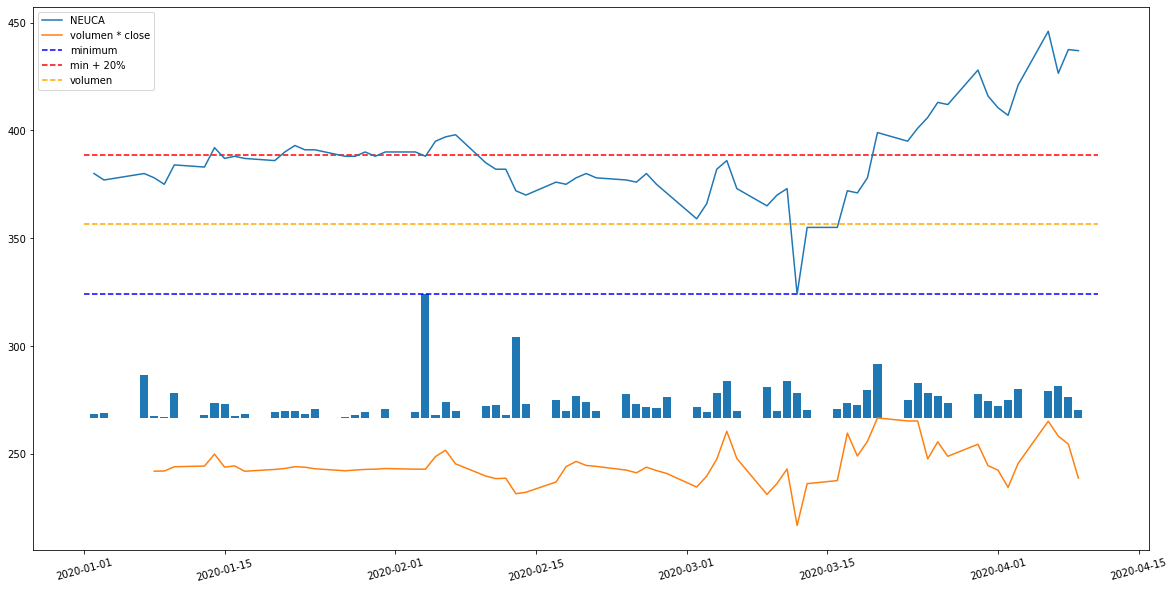

In [53]:
plot_paper(papier,'2020-01-01', str(date.today()))

In [54]:
(current,
data_max_before_crisis,
 data_crises_min,
 data_max_after_drop,
 data_min_after_max,
date_max_after_drop) = prepare_stats_forone(papier, before_crises, big_drop_date)

In [55]:
print(f'Paper: {papier}, currently at {current[0]}, with potential \
{round(data_max_before_crisis*100/current[0]-100, 2)}% to top')
print(f'Max before crisis: {data_max_before_crisis}')
print(f'Crisis bottom: {data_crises_min}')
print(f'Max after crisis drop: {data_max_after_drop}, at {date_max_after_drop[0]}')
print(f'Stats after Max: {data_min_after_max.values}')

Paper: NEUCA, currently at 437.0, with potential -8.92% to top
Max before crisis: 398.0
Crisis bottom: 324.0
Max after crisis drop: 446.0, at 2020-04-06 00:00:00
Stats after Max: [446.  426.5 437.5 437. ]


## Skaner

In [56]:
before_crisis = '2020-02-17'
top_bottom = '2020-03-12'
new_year = '2020-01-01'
last_y_quarter = '2019-10-01'
last_y_mid = '2019-06-03'

df_cols = ['ticker', 'current', 'before_crisis', 'last_y_q', 'last_y_mid',
           'crisis_bottom', 
           'max_after_crisis', 'max_before_crisis']

### All papers

In [93]:
skaner_df = pd.DataFrame(columns=df_cols)
for w in tqdm(all_stocks):
    
    df = prepare_data(w)
   
    skaner_df = pd.concat([skaner_df,
                       pd.DataFrame([[
                    df.TICKER[0],
                    df.loc[:,'CLOSE'].tail(1).values[0],
                    df.loc[df.index == before_crisis ,'CLOSE'].max(),
                    df.loc[df.index == last_y_quarter ,'CLOSE'].max(),
                           df.loc[df.index == last_y_mid,'CLOSE'].max(),
                    df.loc[(df.index >= top_bottom) & (df.index <= today),'CLOSE'].min(),
                    df.loc[df.index > top_bottom ,'CLOSE'].max(),
                    df.loc[(df.index >= last_y_quarter) & (df.index <= before_crisis),'CLOSE'].max()
                    
                       ]],
                                    columns=df_cols)], axis = 0)

100%|██████████| 1957/1957 [00:05<00:00, 362.91it/s]


In [94]:
skaner_df.loc[:,'growth_quarter'] = round(skaner_df.loc[:,'before_crisis'] * 100 / skaner_df.loc[:,'last_y_q'] - 100, 2)
skaner_df.loc[:,'growth_mid'] = round(skaner_df.loc[:,'last_y_q'] * 100 / skaner_df.loc[:,'last_y_mid'] - 100, 2)
skaner_df.loc[:,'growth_from_crisis'] = round(skaner_df.loc[:,'max_after_crisis'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_potential'] = round((skaner_df.loc[:,'max_before_crisis'] * 100) / skaner_df.loc[:,'current'] - 100, 2)
skaner_df.loc[:,'drop_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'max_before_crisis'] - 100, 2)

In [95]:
skaner_df_see = skaner_df.loc[
#     (skaner_df.growth_quarter > 0) 
#         & (skaner_df.growth_mid > 0) 
        #& (skaner_df.drop_current < 0) 
        (skaner_df.growth_current > 20)
                              ,:].sort_values('drop_current', ascending=True)

In [96]:
skaner_df_see = skaner_df_see.loc[
    skaner_df_see.ticker.apply(lambda x: 
                               False if ('RCFL' in x) 
                               | ('INTLGLD' in x) 
                               | ('RCFS' in x)
                               | ('INTL' in x)
                               | ('INTS' in x)
                               | ('RCTL' in x)
                               | ('BETA' in x)
                               | ('RCL' in x) else True).values,]

In [97]:
skaner_df_see.shape

(202, 14)

In [98]:
skaner_df_see.tail(100)

,ticker,current,before_crisis,last_y_q,last_y_mid,crisis_bottom,max_after_crisis,max_before_crisis,growth_quarter,growth_mid,growth_from_crisis,growth_current,growth_potential,drop_current
0,VOTUM,11.000,14.100,11.4000,8.1800,8.200,11.250,14.950,23.68,39.36,37.20,34.15,35.91,-26.42
0,FERRO,13.500,17.250,13.7000,13.9000,10.300,13.500,18.250,25.91,-1.44,31.07,31.07,35.19,-26.03
0,DIGITREE,4.440,4.900,NaN,NaN,3.400,4.480,6.000,NaN,NaN,31.76,30.59,35.14,-26.00
0,RADPOL,1.170,1.455,1.1400,1.4150,0.940,1.180,1.580,27.63,-19.43,25.53,24.47,35.04,-25.95
0,WIRTUALNA,64.000,84.600,66.8000,58.0000,47.400,64.000,86.400,26.65,15.17,35.02,35.02,35.00,-25.93
0,DECORA,14.900,19.700,17.5000,18.1000,11.900,16.000,20.000,12.57,-3.31,34.45,25.21,34.23,-25.50
0,ADIUVO,5.740,6.300,7.3000,8.2600,4.700,7.260,7.700,-13.70,-11.62,54.47,22.13,34.15,-25.45
0,TORPOL,6.640,8.900,6.8800,6.9600,5.000,6.900,8.900,29.36,-1.15,38.00,32.80,34.04,-25.39
0,POLICE,10.600,10.500,NaN,14.5000,7.100,10.600,14.200,NaN,NaN,49.30,49.30,33.96,-25.35
0,VIVID,1.312,1.714,1.3000,1.4400,0.980,1.438,1.750,31.85,-9.72,46.73,33.88,33.38,-25.03


## Monitoring

In [89]:
to_monitor_list = ['ASBIS', 'UNIMOT',
            'CLNPHARMA', 'SUNEX', 
            'ELKOP', 'ABPL', 
            'MLSYSTEM',
            'AMBRA', 'INTERAOLT', 
            'LENA', 'ARCHICOM', 
            'KREC', 'INTERCARS', 'WIRTUALNA',
            'PLAY', 'MOSTALPLC', 'WIELTON']

In [90]:
df_merged = prepare_data(to_monitor_list[0]).loc[:,['CLOSE', 'TICKER', 'VOL']].copy()
df_merged = df_merged.loc[df_merged.index >= '2020-01-01'].copy()
df_merged.loc[:,'CLOSE'] = ((df_merged.loc[:,'CLOSE'] - df_merged.loc[:,'CLOSE'].mean()) 
                            / df_merged.loc[:,'CLOSE'].std())
df_merged.loc[:,'VOL'] = ((df_merged.loc[:,'VOL'] - df_merged.loc[:,'VOL'].mean()) 
                            / df_merged.loc[:,'VOL'].std())

In [91]:
for a in tqdm(to_monitor_list[1:]):

    df = prepare_data(a)
    df = df.loc[df.index >= '2020-01-01', ['CLOSE', 'TICKER', 'VOL']].copy()
    df.loc[:,'CLOSE'] = ((df.loc[:,'CLOSE'] - df.loc[:,'CLOSE'].mean()) 
                                / df.loc[:,'CLOSE'].std())
    df.loc[:,'VOL'] = ((df.loc[:,'VOL'] - df.loc[:,'VOL'].mean()) 
                                / df.loc[:,'VOL'].std())
        
    df_merged = pd.merge(df_merged, df,
                     left_index=True,
                     right_index=True,
                        how = 'outer')

100%|██████████| 16/16 [00:00<00:00, 79.36it/s]


In [92]:
df_stats = pd.DataFrame()

In [93]:
for t in ['CLOSE', 'VOL']:
    df_merged_limited = df_merged.loc[:, [c for c in df_merged.columns if t in c]]
    df_stats.loc[:,f'{t}_sum'] = df_merged_limited.sum(axis = 1)
    df_stats.loc[:,f'{t}_std'] = df_merged_limited.std(axis = 1)
    df_stats.loc[:,f'{t}_mean'] = df_merged_limited.mean(axis = 1)
    df_stats.loc[:,f'{t}_median'] = df_merged_limited.median(axis = 1)
    df_stats.loc[:,f'{t}_q90'] = df_merged_limited.quantile(0.9,axis = 1)
    df_stats.loc[:,f'{t}_q10'] = df_merged_limited.quantile(0.1,axis = 1)

In [94]:
for n in [5, 20]:
    
    df_stats.loc[:,f'CLOSE_mean_rolling{n}'] = df_stats.loc[:,'CLOSE_mean'].rolling(n).mean()
    df_stats.loc[:,f'VOL_mean_rolling{n}'] = df_stats.loc[:,'VOL_mean'].rolling(n).mean()

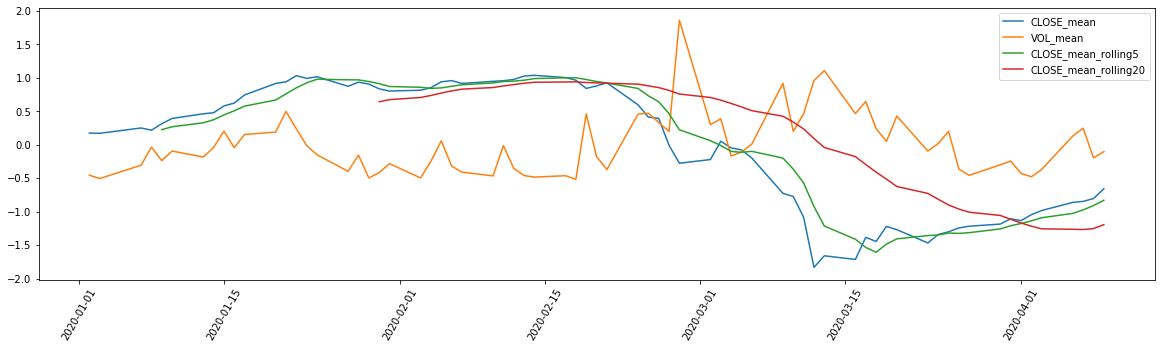

In [95]:
plt.figure(figsize=(20,5))
cols_to_plot = ['CLOSE_mean', 'VOL_mean',
                        'CLOSE_mean_rolling5',
                        'CLOSE_mean_rolling20']
plt.plot(df_stats.loc[:,cols_to_plot])
plt.xticks(rotation=60)
plt.legend(cols_to_plot)

## Model

In [99]:
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.metrics import confusion_matrix

In [55]:
def transform_one_paper(df):
    
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'bin_' + col] = 0
        df.loc[df.loc[:,col] > df.loc[:,col + '_shifted'],'bin_' + col] = 1

    #df.loc[:, 'target'] = df.loc[:, 'bin_OPEN'].shift(-1)
    
    df.loc[:, 'target'] = np.nan
    df.loc[df.loc[:, 'LOW'].shift(-1) > df.loc[:, 'LOW'], 'target'] = 1
    df.loc[df.loc[:, 'LOW'].shift(-1) <= df.loc[:, 'LOW'], 'target'] = 0
    
    for a in [c for c in df.columns if 'bin' in c]:
        for i in [1,2,3,4,5]:
            df.loc[:,f'binhist{i}_' + a] = df.loc[:,a].shift(i)
            
    for b in [c for c in df.columns if ('bin_' in c) & ('binhist' not in c)]:
        for g in [3, 5, 10, 20]:
            df.loc[:,f'binroll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
    return df

In [485]:
def transform_one_paper_ch(df):
    
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
        
    df.loc[:,'chng_OPEN1_CLOSE'] = (df.loc[:,'OPEN'].shift(1) * 100 / df.loc[:,'CLOSE']) - 100
    df.loc[:,'chng_LOW1_CLOSE'] = (df.loc[:,'LOW'].shift(1) * 100 / df.loc[:,'CLOSE']) - 100
    df.loc[:,'chng_HIGH1_CLOSE'] = (df.loc[:,'HIGH'].shift(1) * 100 / df.loc[:,'CLOSE']) - 100
        
    df.loc[:,'move_strength_abs'] =  abs(df.loc[:,'chng_CLOSE']) * abs(df.loc[:,'chng_VOL'])
    df.loc[:,'move_strength'] =  (df.loc[:,'chng_CLOSE']) * (df.loc[:,'chng_VOL'])
    
    
### COMPARISON SECTION
#are you on losing strike?
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        for i in [5,10,20,30,60]:
            df.loc[:,f'comp{i}d_max' + col] = df.loc[:,col].rolling(i).max()
            df.loc[:,f'comp{i}d_max' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_max' + col]) - 100
            
            df.loc[:,f'comp{i}d_min' + col] = df.loc[:,col].rolling(i).min()
            df.loc[:,f'comp{i}d_min' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_min' + col]) - 100
            
            df.loc[:,f'comp{i}d_mean' + col] = df.loc[:,col].rolling(i).max()
            df.loc[:,f'comp{i}d_mean' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_mean' + col]) - 100
##       
#     df.loc[df.loc[:, 'LOW'] > df.loc[:, 'CLOSE'],'comp_CLOSE_LOWER'] = 1
#     df.loc[df.loc[:, 'LOW'] <= df.loc[:, 'CLOSE'],'comp_CLOSE_LOWER'] = 0
    
#     df.loc[df.loc[:, 'LOW'].shift(1) > df.loc[:, 'CLOSE'],'comp_CLOSE_LOWER_1'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(1) <= df.loc[:, 'CLOSE'],'comp_CLOSE_LOWER_1'] = 0
    
#     df.loc[df.loc[:, 'HIGH'].shift(1) > df.loc[:, 'CLOSE'],'comp_CLOSE_HIGH_1'] = 1
#     df.loc[df.loc[:, 'HIGH'].shift(1) <= df.loc[:, 'CLOSE'],'comp_CLOSE_HIGH_1'] = 0
    
#     df.loc[df.loc[:, 'OPEN'].shift(1) > df.loc[:, 'CLOSE'],'comp_CLOSE_OPEN_1'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(1) <= df.loc[:, 'CLOSE'],'comp_CLOSE_OPEN_1'] = 0
      
#     df.loc[df.loc[:, 'CLOSE'] > df.loc[:, 'OPEN'],'comp_CLOSE_OPEN'] = 1
#     df.loc[df.loc[:, 'CLOSE'] <= df.loc[:, 'OPEN'],'comp_CLOSE_OPEN'] = 0
    
#     df.loc[:,'same_CLOSE_LOW'] = 0
#     df.loc[df.loc[:, 'CLOSE'] == df.loc[:, 'LOW'],'same_CLOSE_LOW'] = 1
#     df.loc[:,'same_CLOSE_HIGH'] = 0
#     df.loc[df.loc[:, 'CLOSE'] == df.loc[:, 'HIGH'],'same_CLOSE_HIGH'] = 1
    
#     df.loc[:,'same_OPEN_LOW'] = 0
#     df.loc[df.loc[:, 'OPEN'] == df.loc[:, 'LOW'],'same_OPEN_LOW'] = 1
#     df.loc[:,'same_OPEN_HIGH'] = 0
#     df.loc[df.loc[:, 'OPEN'] == df.loc[:, 'HIGH'],'same_OPEN_HIGH'] = 1
    
    
### FUTURE SECTION ###

#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 0
    
    #df.loc[:, 'fut_OPEN_CLOSE_chng'] = (df.loc[:, 'OPEN'].shift(-1) * 100 / df.loc[:, 'CLOSE']) - 100
    
#     df.loc[:, 'chng_rel_OPEN'] = np.nan
#     df.loc[df.loc[:, 'HIGH'] > df.loc[:, 'OPEN'] * 1.01,'chng_rel_OPEN'] = 1
#     df.loc[df.loc[:, 'HIGH'] <= df.loc[:, 'OPEN'] * 1.01, 'chng_rel_OPEN'] = 0
    
#     df.loc[df.loc[:, 'OPEN'] < df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 1
#     df.loc[df.loc[:, 'OPEN'] >= df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 0


### DIFFS SECTION ###
    df.loc[:,'diff_LOW_HIGH'] = (df.loc[:,'HIGH'] - df.loc[:,'LOW']) / df.loc[:,'HIGH']
    df.loc[:,'diff_OPEN_CLOSE'] = (df.loc[:,'OPEN'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_LOW_CLOSE'] = (df.loc[:,'CLOSE'] - df.loc[:,'LOW']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_HIGH_CLOSE'] = (df.loc[:,'HIGH'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    
    
    #historic features

#     for a in [c for c in df.columns if ('chng_' in c) | ('move_' in c) | ('comp_' in c)]:
#         for i in [1, 2, 3, 4, 5]:
#             df.loc[:,f'hist{i}_' + a] = df.loc[:,a].shift(i)

### GET SOME MEANS ###
#Trye min and maxes and some std?
    for b in [c for c in df.columns if (('chng_' in c) 
                                        | ('move_' in c) 
                                        | ('diff_' in c)
                                       | ('same_' in c)) & ('hist' not in c)]:
        for g in [2, 3, 5, 10, 20]:
            df.loc[:,f'roll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
            df.loc[:,f'roll{g}min_' + b] = df.loc[:,b].rolling(g).min()
            df.loc[:,f'roll{g}max_' + b] = df.loc[:,b].rolling(g).max()

### TARGET SECTION ###
#pick one the of the available sections

### HIGHER HIGH ###
#     df.loc[df.loc[:, 'HIGH'].shift(-1) > df.loc[:, 'HIGH'],'target'] = 1
#     df.loc[df.loc[:, 'HIGH'].shift(-1) <= df.loc[:, 'HIGH'],'target'] = 0
    
### HIGHER OPENING ###
    df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'target'] = 1
    df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'target'] = 0
    
    
#     df.loc[:, 'target'] = df.loc[:, 'chng_rel_OPEN'].shift(-1)
#    df.loc[:,'target'] = df.loc[:,'comp_CLOSE_OPEN'].shift(-1)
    
#df.loc[:, 'target'] = df.loc[:,'diff_LOW_HIGH'].shift(-1)
    
#     df.loc[df.loc[:, 'LOW'].shift(-1) > df.loc[:, 'CLOSE'],'target'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(-1) <= df.loc[:, 'CLOSE'],'target'] = 0

#     df.loc[df.loc[:, 'LOW'].shift(-1) > df.loc[:, 'CLOSE'], 'target'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(-1) <= df.loc[:, 'CLOSE'], 'target'] = 0
    
#     df.loc[:, 'target'] = (df.loc[:, 'OPEN'].shift(-1) * 100 / df.loc[:, 'CLOSE']) - 100
#     df.loc[:, 'target'] = df.loc[:, 'chng_OPEN'].shift(-1)
#     df.loc[:, 'target'] = df.loc[:, 'bin_OPEN'].shift(-1)
    
#     df.loc[df.loc[:, 'LOW'].shift(-1) > df.loc[:, 'LOW'], 'target'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(-1) <= df.loc[:, 'LOW'], 'target'] = 0
    
    return df

In [428]:
def transform_one_index(df):
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
    return df

In [486]:
df_merged = pd.DataFrame()

for p in tqdm(skaner_df_see.ticker.values):
    
    df = prepare_data(p)
        
    df = transform_one_paper_ch(df) 
    df = df.dropna()
    
    df_merged = pd.concat([df_merged, df])
    del df

100%|██████████| 202/202 [04:35<00:00,  1.36s/it]


In [487]:
df_indexes_merged = pd.DataFrame()

for p in tqdm(all_indekses):
    
    df = prepare_index(p)
        
    df = transform_one_index(df) 
    #df = df.dropna()
    
    df_indexes_merged = pd.concat([df_indexes_merged, df])
    del df

100%|██████████| 23/23 [00:00<00:00, 49.80it/s]


In [488]:
df_indexes_merged = df_indexes_merged.pivot_table(index='DTYYYYMMDD', columns='TICKER', values='chng_CLOSE')
df_indexes_merged = df_indexes_merged.agg(['mean', 'max', 'min', 'std'], axis = 1)
df_indexes_merged = df_indexes_merged.add_prefix('foreign_stocks_')

df_merged = df_merged.merge(df_indexes_merged, left_index=True, right_index=True, how = 'left')

In [489]:
train_cols = [c for c in df_merged.columns if ('chng' in c) | ('move' in c) 
              | ('comp' in c) | ('fut' in c) | ('diff' in c) | ('same' in c)]

train_cols = train_cols + list(df_indexes_merged.columns)

In [490]:
#train_cols = train_cols_limited

df = df_merged.copy()

cut_date = '2020-01-01'
train_data = df.loc[df.index < cut_date,train_cols]
eval_data = df.loc[df.index >= cut_date,train_cols]
train_labels = df.loc[df.index < cut_date,'target'].values
eval_labels = df.loc[df.index >= cut_date,'target'].values

In [491]:
# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=10000,
                           learning_rate=0.02,
                           depth=3,
                          thread_count=4,
                          eval_metric='AUC',
                          task_type='GPU')

# # # Initialize CatBoostRegressor
# model = CatBoostRegressor(iterations=2000,
#                            learning_rate=0.05,
#                            depth=3,
#                           thread_count=4,
#                           eval_metric='RMSE')

In [492]:
model.fit(train_data, train_labels, 
          eval_set=(eval_data[:-1], eval_labels[:-1]),
         early_stopping_rounds=100, use_best_model=True)

0:	learn: 0.6184051	test: 0.6077704	best: 0.6077704 (0)	total: 12.4ms	remaining: 2m 3s
1:	learn: 0.6270585	test: 0.6184198	best: 0.6184198 (1)	total: 25ms	remaining: 2m 4s
2:	learn: 0.6307688	test: 0.6188011	best: 0.6188011 (2)	total: 37.6ms	remaining: 2m 5s
3:	learn: 0.6335053	test: 0.6228574	best: 0.6228574 (3)	total: 50.3ms	remaining: 2m 5s
4:	learn: 0.6362695	test: 0.6256660	best: 0.6256660 (4)	total: 63.3ms	remaining: 2m 6s
5:	learn: 0.6420078	test: 0.6287037	best: 0.6287037 (5)	total: 75.9ms	remaining: 2m 6s
6:	learn: 0.6430664	test: 0.6303070	best: 0.6303070 (6)	total: 88.9ms	remaining: 2m 6s
7:	learn: 0.6426006	test: 0.6286797	best: 0.6303070 (6)	total: 102ms	remaining: 2m 7s
8:	learn: 0.6415028	test: 0.6279285	best: 0.6303070 (6)	total: 115ms	remaining: 2m 7s
9:	learn: 0.6428733	test: 0.6285311	best: 0.6303070 (6)	total: 127ms	remaining: 2m 7s
10:	learn: 0.6425044	test: 0.6294537	best: 0.6303070 (6)	total: 140ms	remaining: 2m 7s
11:	learn: 0.6423245	test: 0.6298957	best: 0.630

107:	learn: 0.6630700	test: 0.6438640	best: 0.6439072 (106)	total: 1.24s	remaining: 1m 53s
108:	learn: 0.6631201	test: 0.6440100	best: 0.6440100 (108)	total: 1.25s	remaining: 1m 53s
109:	learn: 0.6632327	test: 0.6442882	best: 0.6442882 (109)	total: 1.26s	remaining: 1m 53s
110:	learn: 0.6633794	test: 0.6443373	best: 0.6443373 (110)	total: 1.27s	remaining: 1m 53s
111:	learn: 0.6634885	test: 0.6444280	best: 0.6444280 (111)	total: 1.28s	remaining: 1m 53s
112:	learn: 0.6636133	test: 0.6445090	best: 0.6445090 (112)	total: 1.29s	remaining: 1m 53s
113:	learn: 0.6638067	test: 0.6447642	best: 0.6447642 (113)	total: 1.31s	remaining: 1m 53s
114:	learn: 0.6639066	test: 0.6448192	best: 0.6448192 (114)	total: 1.32s	remaining: 1m 53s
115:	learn: 0.6640079	test: 0.6448308	best: 0.6448308 (115)	total: 1.33s	remaining: 1m 53s
116:	learn: 0.6641726	test: 0.6449252	best: 0.6449252 (116)	total: 1.34s	remaining: 1m 53s
117:	learn: 0.6642438	test: 0.6449859	best: 0.6449859 (117)	total: 1.35s	remaining: 1m 53s

202:	learn: 0.6702531	test: 0.6500007	best: 0.6500007 (202)	total: 2.25s	remaining: 1m 48s
203:	learn: 0.6703172	test: 0.6500569	best: 0.6500569 (203)	total: 2.26s	remaining: 1m 48s
204:	learn: 0.6704166	test: 0.6501277	best: 0.6501277 (204)	total: 2.27s	remaining: 1m 48s
205:	learn: 0.6704340	test: 0.6501494	best: 0.6501494 (205)	total: 2.28s	remaining: 1m 48s
206:	learn: 0.6704753	test: 0.6503133	best: 0.6503133 (206)	total: 2.29s	remaining: 1m 48s
207:	learn: 0.6705055	test: 0.6502973	best: 0.6503133 (206)	total: 2.3s	remaining: 1m 48s
208:	learn: 0.6705567	test: 0.6503670	best: 0.6503670 (208)	total: 2.31s	remaining: 1m 48s
209:	learn: 0.6705873	test: 0.6503499	best: 0.6503670 (208)	total: 2.32s	remaining: 1m 48s
210:	learn: 0.6706878	test: 0.6503069	best: 0.6503670 (208)	total: 2.33s	remaining: 1m 48s
211:	learn: 0.6707790	test: 0.6503581	best: 0.6503670 (208)	total: 2.35s	remaining: 1m 48s
212:	learn: 0.6708196	test: 0.6503492	best: 0.6503670 (208)	total: 2.36s	remaining: 1m 48s


309:	learn: 0.6750196	test: 0.6546509	best: 0.6546509 (309)	total: 3.48s	remaining: 1m 48s
310:	learn: 0.6750506	test: 0.6545963	best: 0.6546509 (309)	total: 3.49s	remaining: 1m 48s
311:	learn: 0.6750872	test: 0.6546844	best: 0.6546844 (311)	total: 3.5s	remaining: 1m 48s
312:	learn: 0.6751090	test: 0.6547232	best: 0.6547232 (312)	total: 3.52s	remaining: 1m 48s
313:	learn: 0.6751425	test: 0.6546644	best: 0.6547232 (312)	total: 3.53s	remaining: 1m 48s
314:	learn: 0.6751606	test: 0.6547054	best: 0.6547232 (312)	total: 3.54s	remaining: 1m 48s
315:	learn: 0.6751931	test: 0.6548758	best: 0.6548758 (315)	total: 3.55s	remaining: 1m 48s
316:	learn: 0.6752193	test: 0.6548888	best: 0.6548888 (316)	total: 3.56s	remaining: 1m 48s
317:	learn: 0.6752896	test: 0.6549611	best: 0.6549611 (317)	total: 3.57s	remaining: 1m 48s
318:	learn: 0.6753225	test: 0.6549706	best: 0.6549706 (318)	total: 3.58s	remaining: 1m 48s
319:	learn: 0.6753525	test: 0.6550006	best: 0.6550006 (319)	total: 3.59s	remaining: 1m 48s


417:	learn: 0.6780131	test: 0.6584840	best: 0.6584840 (417)	total: 4.7s	remaining: 1m 47s
418:	learn: 0.6780362	test: 0.6585169	best: 0.6585169 (418)	total: 4.71s	remaining: 1m 47s
419:	learn: 0.6780630	test: 0.6585760	best: 0.6585760 (419)	total: 4.72s	remaining: 1m 47s
420:	learn: 0.6780826	test: 0.6585946	best: 0.6585946 (420)	total: 4.73s	remaining: 1m 47s
421:	learn: 0.6781059	test: 0.6586081	best: 0.6586081 (421)	total: 4.75s	remaining: 1m 47s
422:	learn: 0.6781302	test: 0.6587240	best: 0.6587240 (422)	total: 4.75s	remaining: 1m 47s
423:	learn: 0.6781501	test: 0.6587520	best: 0.6587520 (423)	total: 4.77s	remaining: 1m 47s
424:	learn: 0.6781760	test: 0.6587686	best: 0.6587686 (424)	total: 4.78s	remaining: 1m 47s
425:	learn: 0.6782100	test: 0.6588123	best: 0.6588123 (425)	total: 4.79s	remaining: 1m 47s
426:	learn: 0.6782425	test: 0.6588869	best: 0.6588869 (426)	total: 4.8s	remaining: 1m 47s
427:	learn: 0.6782622	test: 0.6589279	best: 0.6589279 (427)	total: 4.81s	remaining: 1m 47s
4

526:	learn: 0.6803395	test: 0.6621153	best: 0.6621534 (520)	total: 5.91s	remaining: 1m 46s
527:	learn: 0.6803618	test: 0.6621274	best: 0.6621534 (520)	total: 5.92s	remaining: 1m 46s
528:	learn: 0.6803833	test: 0.6621438	best: 0.6621534 (520)	total: 5.93s	remaining: 1m 46s
529:	learn: 0.6804072	test: 0.6621640	best: 0.6621640 (529)	total: 5.94s	remaining: 1m 46s
530:	learn: 0.6804294	test: 0.6621692	best: 0.6621692 (530)	total: 5.95s	remaining: 1m 46s
531:	learn: 0.6804528	test: 0.6621681	best: 0.6621692 (530)	total: 5.96s	remaining: 1m 46s
532:	learn: 0.6804649	test: 0.6621724	best: 0.6621724 (532)	total: 5.97s	remaining: 1m 46s
533:	learn: 0.6804774	test: 0.6621318	best: 0.6621724 (532)	total: 5.98s	remaining: 1m 46s
534:	learn: 0.6804949	test: 0.6621532	best: 0.6621724 (532)	total: 5.99s	remaining: 1m 46s
535:	learn: 0.6805074	test: 0.6621701	best: 0.6621724 (532)	total: 6s	remaining: 1m 46s
536:	learn: 0.6805294	test: 0.6621845	best: 0.6621845 (536)	total: 6.01s	remaining: 1m 45s
53

626:	learn: 0.6818449	test: 0.6636231	best: 0.6636231 (626)	total: 6.93s	remaining: 1m 43s
627:	learn: 0.6818650	test: 0.6636354	best: 0.6636354 (627)	total: 6.94s	remaining: 1m 43s
628:	learn: 0.6818753	test: 0.6636764	best: 0.6636764 (628)	total: 6.95s	remaining: 1m 43s
629:	learn: 0.6818922	test: 0.6637598	best: 0.6637598 (629)	total: 6.96s	remaining: 1m 43s
630:	learn: 0.6819197	test: 0.6637895	best: 0.6637895 (630)	total: 6.97s	remaining: 1m 43s
631:	learn: 0.6819367	test: 0.6638254	best: 0.6638254 (631)	total: 6.99s	remaining: 1m 43s
632:	learn: 0.6819600	test: 0.6639152	best: 0.6639152 (632)	total: 7s	remaining: 1m 43s
633:	learn: 0.6819712	test: 0.6639169	best: 0.6639169 (633)	total: 7s	remaining: 1m 43s
634:	learn: 0.6819960	test: 0.6639368	best: 0.6639368 (634)	total: 7.02s	remaining: 1m 43s
635:	learn: 0.6820113	test: 0.6639505	best: 0.6639505 (635)	total: 7.03s	remaining: 1m 43s
636:	learn: 0.6820225	test: 0.6639435	best: 0.6639505 (635)	total: 7.04s	remaining: 1m 43s
637:	

731:	learn: 0.6832761	test: 0.6658204	best: 0.6658204 (731)	total: 8.15s	remaining: 1m 43s
732:	learn: 0.6832962	test: 0.6658598	best: 0.6658598 (732)	total: 8.16s	remaining: 1m 43s
733:	learn: 0.6833082	test: 0.6658657	best: 0.6658657 (733)	total: 8.18s	remaining: 1m 43s
734:	learn: 0.6833141	test: 0.6658617	best: 0.6658657 (733)	total: 8.19s	remaining: 1m 43s
735:	learn: 0.6833236	test: 0.6658666	best: 0.6658666 (735)	total: 8.2s	remaining: 1m 43s
736:	learn: 0.6833313	test: 0.6658795	best: 0.6658795 (736)	total: 8.21s	remaining: 1m 43s
737:	learn: 0.6833493	test: 0.6659369	best: 0.6659369 (737)	total: 8.22s	remaining: 1m 43s
738:	learn: 0.6833564	test: 0.6659523	best: 0.6659523 (738)	total: 8.24s	remaining: 1m 43s
739:	learn: 0.6833763	test: 0.6659718	best: 0.6659718 (739)	total: 8.25s	remaining: 1m 43s
740:	learn: 0.6833939	test: 0.6659852	best: 0.6659852 (740)	total: 8.26s	remaining: 1m 43s
741:	learn: 0.6834062	test: 0.6659971	best: 0.6659971 (741)	total: 8.28s	remaining: 1m 43s


823:	learn: 0.6843330	test: 0.6666951	best: 0.6666951 (823)	total: 9.18s	remaining: 1m 42s
824:	learn: 0.6843457	test: 0.6666942	best: 0.6666951 (823)	total: 9.19s	remaining: 1m 42s
825:	learn: 0.6843537	test: 0.6667010	best: 0.6667010 (825)	total: 9.2s	remaining: 1m 42s
826:	learn: 0.6843657	test: 0.6667714	best: 0.6667714 (826)	total: 9.21s	remaining: 1m 42s
827:	learn: 0.6843765	test: 0.6668054	best: 0.6668054 (827)	total: 9.22s	remaining: 1m 42s
828:	learn: 0.6843892	test: 0.6667929	best: 0.6668054 (827)	total: 9.23s	remaining: 1m 42s
829:	learn: 0.6843971	test: 0.6667977	best: 0.6668054 (827)	total: 9.24s	remaining: 1m 42s
830:	learn: 0.6844078	test: 0.6668021	best: 0.6668054 (827)	total: 9.25s	remaining: 1m 42s
831:	learn: 0.6844130	test: 0.6667948	best: 0.6668054 (827)	total: 9.26s	remaining: 1m 42s
832:	learn: 0.6844212	test: 0.6668065	best: 0.6668065 (832)	total: 9.28s	remaining: 1m 42s
833:	learn: 0.6844267	test: 0.6668084	best: 0.6668084 (833)	total: 9.29s	remaining: 1m 42s


921:	learn: 0.6853023	test: 0.6677445	best: 0.6677502 (920)	total: 10.2s	remaining: 1m 40s
922:	learn: 0.6853097	test: 0.6677562	best: 0.6677562 (922)	total: 10.2s	remaining: 1m 40s
923:	learn: 0.6853193	test: 0.6677538	best: 0.6677562 (922)	total: 10.2s	remaining: 1m 40s
924:	learn: 0.6853259	test: 0.6677114	best: 0.6677562 (922)	total: 10.2s	remaining: 1m 40s
925:	learn: 0.6853318	test: 0.6677172	best: 0.6677562 (922)	total: 10.2s	remaining: 1m 40s
926:	learn: 0.6853403	test: 0.6677282	best: 0.6677562 (922)	total: 10.3s	remaining: 1m 40s
927:	learn: 0.6853485	test: 0.6677527	best: 0.6677562 (922)	total: 10.3s	remaining: 1m 40s
928:	learn: 0.6853582	test: 0.6677589	best: 0.6677589 (928)	total: 10.3s	remaining: 1m 40s
929:	learn: 0.6853665	test: 0.6677805	best: 0.6677805 (929)	total: 10.3s	remaining: 1m 40s
930:	learn: 0.6853763	test: 0.6677841	best: 0.6677841 (930)	total: 10.3s	remaining: 1m 40s
931:	learn: 0.6853850	test: 0.6677884	best: 0.6677884 (931)	total: 10.3s	remaining: 1m 40s

1021:	learn: 0.6861897	test: 0.6684238	best: 0.6684238 (1016)	total: 11.2s	remaining: 1m 38s
1022:	learn: 0.6861971	test: 0.6684367	best: 0.6684367 (1022)	total: 11.2s	remaining: 1m 38s
1023:	learn: 0.6862065	test: 0.6684318	best: 0.6684367 (1022)	total: 11.3s	remaining: 1m 38s
1024:	learn: 0.6862181	test: 0.6684426	best: 0.6684426 (1024)	total: 11.3s	remaining: 1m 38s
1025:	learn: 0.6862282	test: 0.6684569	best: 0.6684569 (1025)	total: 11.3s	remaining: 1m 38s
1026:	learn: 0.6862391	test: 0.6684895	best: 0.6684895 (1026)	total: 11.3s	remaining: 1m 38s
1027:	learn: 0.6862478	test: 0.6685116	best: 0.6685116 (1027)	total: 11.3s	remaining: 1m 38s
1028:	learn: 0.6862590	test: 0.6685180	best: 0.6685180 (1028)	total: 11.3s	remaining: 1m 38s
1029:	learn: 0.6862648	test: 0.6685311	best: 0.6685311 (1029)	total: 11.3s	remaining: 1m 38s
1030:	learn: 0.6862665	test: 0.6685364	best: 0.6685364 (1030)	total: 11.3s	remaining: 1m 38s
1031:	learn: 0.6862785	test: 0.6685577	best: 0.6685577 (1031)	total: 1

1118:	learn: 0.6869641	test: 0.6691924	best: 0.6691924 (1118)	total: 12.3s	remaining: 1m 37s
1119:	learn: 0.6869732	test: 0.6692408	best: 0.6692408 (1119)	total: 12.3s	remaining: 1m 37s
1120:	learn: 0.6869822	test: 0.6692764	best: 0.6692764 (1120)	total: 12.3s	remaining: 1m 37s
1121:	learn: 0.6869918	test: 0.6692847	best: 0.6692847 (1121)	total: 12.3s	remaining: 1m 37s
1122:	learn: 0.6869956	test: 0.6692932	best: 0.6692932 (1122)	total: 12.3s	remaining: 1m 37s
1123:	learn: 0.6870031	test: 0.6692887	best: 0.6692932 (1122)	total: 12.3s	remaining: 1m 37s
1124:	learn: 0.6870093	test: 0.6693109	best: 0.6693109 (1124)	total: 12.3s	remaining: 1m 37s
1125:	learn: 0.6870183	test: 0.6693159	best: 0.6693159 (1125)	total: 12.3s	remaining: 1m 37s
1126:	learn: 0.6870233	test: 0.6693271	best: 0.6693271 (1126)	total: 12.3s	remaining: 1m 37s
1127:	learn: 0.6870313	test: 0.6693379	best: 0.6693379 (1127)	total: 12.3s	remaining: 1m 37s
1128:	learn: 0.6870492	test: 0.6693502	best: 0.6693502 (1128)	total: 1

1212:	learn: 0.6876578	test: 0.6699626	best: 0.6699626 (1212)	total: 13.3s	remaining: 1m 36s
1213:	learn: 0.6876618	test: 0.6699595	best: 0.6699626 (1212)	total: 13.3s	remaining: 1m 36s
1214:	learn: 0.6876695	test: 0.6699708	best: 0.6699708 (1214)	total: 13.3s	remaining: 1m 36s
1215:	learn: 0.6876716	test: 0.6699730	best: 0.6699730 (1215)	total: 13.3s	remaining: 1m 36s
1216:	learn: 0.6876819	test: 0.6699784	best: 0.6699784 (1216)	total: 13.3s	remaining: 1m 36s
1217:	learn: 0.6876896	test: 0.6699908	best: 0.6699908 (1217)	total: 13.3s	remaining: 1m 36s
1218:	learn: 0.6876996	test: 0.6700090	best: 0.6700090 (1218)	total: 13.3s	remaining: 1m 36s
1219:	learn: 0.6877052	test: 0.6700099	best: 0.6700099 (1219)	total: 13.4s	remaining: 1m 36s
1220:	learn: 0.6877106	test: 0.6700018	best: 0.6700099 (1219)	total: 13.4s	remaining: 1m 36s
1221:	learn: 0.6877187	test: 0.6700146	best: 0.6700146 (1221)	total: 13.4s	remaining: 1m 36s
1222:	learn: 0.6877252	test: 0.6700368	best: 0.6700368 (1222)	total: 1

1301:	learn: 0.6882575	test: 0.6703058	best: 0.6703787 (1290)	total: 14.3s	remaining: 1m 35s
1302:	learn: 0.6882692	test: 0.6702784	best: 0.6703787 (1290)	total: 14.3s	remaining: 1m 35s
1303:	learn: 0.6882756	test: 0.6702946	best: 0.6703787 (1290)	total: 14.3s	remaining: 1m 35s
1304:	learn: 0.6882808	test: 0.6702927	best: 0.6703787 (1290)	total: 14.3s	remaining: 1m 35s
1305:	learn: 0.6882893	test: 0.6702918	best: 0.6703787 (1290)	total: 14.3s	remaining: 1m 35s
1306:	learn: 0.6882944	test: 0.6702843	best: 0.6703787 (1290)	total: 14.3s	remaining: 1m 35s
1307:	learn: 0.6882986	test: 0.6702904	best: 0.6703787 (1290)	total: 14.4s	remaining: 1m 35s
1308:	learn: 0.6883020	test: 0.6702934	best: 0.6703787 (1290)	total: 14.4s	remaining: 1m 35s
1309:	learn: 0.6883118	test: 0.6703082	best: 0.6703787 (1290)	total: 14.4s	remaining: 1m 35s
1310:	learn: 0.6883167	test: 0.6703145	best: 0.6703787 (1290)	total: 14.4s	remaining: 1m 35s
1311:	learn: 0.6883231	test: 0.6703143	best: 0.6703787 (1290)	total: 1

1397:	learn: 0.6889016	test: 0.6705174	best: 0.6706563 (1371)	total: 15.3s	remaining: 1m 34s
1398:	learn: 0.6889068	test: 0.6705279	best: 0.6706563 (1371)	total: 15.3s	remaining: 1m 34s
1399:	learn: 0.6889134	test: 0.6705309	best: 0.6706563 (1371)	total: 15.3s	remaining: 1m 34s
1400:	learn: 0.6889172	test: 0.6705343	best: 0.6706563 (1371)	total: 15.3s	remaining: 1m 34s
1401:	learn: 0.6889240	test: 0.6705453	best: 0.6706563 (1371)	total: 15.3s	remaining: 1m 34s
1402:	learn: 0.6889307	test: 0.6705295	best: 0.6706563 (1371)	total: 15.4s	remaining: 1m 34s
1403:	learn: 0.6889346	test: 0.6705294	best: 0.6706563 (1371)	total: 15.4s	remaining: 1m 34s
1404:	learn: 0.6889381	test: 0.6705388	best: 0.6706563 (1371)	total: 15.4s	remaining: 1m 34s
1405:	learn: 0.6889445	test: 0.6705418	best: 0.6706563 (1371)	total: 15.4s	remaining: 1m 34s
1406:	learn: 0.6889493	test: 0.6705424	best: 0.6706563 (1371)	total: 15.4s	remaining: 1m 34s
1407:	learn: 0.6889594	test: 0.6705804	best: 0.6706563 (1371)	total: 1

1494:	learn: 0.6894877	test: 0.6705055	best: 0.6707334 (1429)	total: 16.3s	remaining: 1m 32s
1495:	learn: 0.6894926	test: 0.6704974	best: 0.6707334 (1429)	total: 16.3s	remaining: 1m 32s
1496:	learn: 0.6895018	test: 0.6704962	best: 0.6707334 (1429)	total: 16.4s	remaining: 1m 32s
1497:	learn: 0.6895111	test: 0.6705137	best: 0.6707334 (1429)	total: 16.4s	remaining: 1m 32s
1498:	learn: 0.6895147	test: 0.6705096	best: 0.6707334 (1429)	total: 16.4s	remaining: 1m 32s
1499:	learn: 0.6895198	test: 0.6705106	best: 0.6707334 (1429)	total: 16.4s	remaining: 1m 32s
1500:	learn: 0.6895269	test: 0.6705229	best: 0.6707334 (1429)	total: 16.4s	remaining: 1m 32s
1501:	learn: 0.6895330	test: 0.6705304	best: 0.6707334 (1429)	total: 16.4s	remaining: 1m 32s
1502:	learn: 0.6895391	test: 0.6705554	best: 0.6707334 (1429)	total: 16.4s	remaining: 1m 32s
1503:	learn: 0.6895445	test: 0.6705550	best: 0.6707334 (1429)	total: 16.4s	remaining: 1m 32s
1504:	learn: 0.6895496	test: 0.6705477	best: 0.6707334 (1429)	total: 1

In [493]:
model.get_feature_importance(prettified=True).head(100)

,Feature Id,Importances
0,diff_HIGH_CLOSE,21.947455
1,foreign_stocks_mean,10.520680
2,diff_LOW_CLOSE,5.798247
3,roll20m_diff_OPEN_CLOSE,4.746925
4,chng_CLOSE,3.558987
5,chng_HIGH,3.150952
6,comp60d_maxVOL,2.892414
7,move_strength_abs,2.607989
8,comp60d_meanVOL,2.084480
9,chng_HIGH1_CLOSE,1.758380


In [494]:
imp = model.get_feature_importance(prettified=True)
train_cols_limited  = imp.loc[imp.Importances >= 0.01, 'Feature Id'].values
len(train_cols) - len(train_cols_limited)

106

#### Analysis categorical

In [564]:
preds_class = model.predict(eval_data)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_data)
# Get predicted RawFormulaVal
preds_raw = model.predict(eval_data, prediction_type='RawFormulaVal')

In [611]:
#preds = preds_class[:-1].astype(int)
preds = preds_proba[:,1].copy()

In [612]:
preds[preds > 0.7] = 1
preds[preds < 1] = 0

In [613]:
preds = preds[:-1].astype(int)

In [614]:
preds.sum()

887

In [615]:
confusion_matrix(eval_labels[:-1].astype(int), preds)

array([[6729,  281],
       [5360,  606]])

In [616]:
tn, fp, fn, tp = confusion_matrix(eval_labels[:-1].astype(int), preds).ravel()
(tn, fp, fn, tp)

(6729, 281, 5360, 606)

In [617]:
(tn + tp) / (tn + tp + fp + fn)

0.5652743526510481

In [618]:
tp / (tp + fp)

0.6832018038331454

In [619]:
df_res = pd.concat([pd.DataFrame(preds_proba), pd.Series(eval_labels)], axis=1)
df_res.columns = ['zero', 'one', 'true']
df_res.groupby('true').mean()

,zero,one
true,,
0.0,0.602604,0.397396
1.0,0.504484,0.495516


In [620]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(1)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(1)
df_res_grouped = df_res.drop('zero', axis = 1)

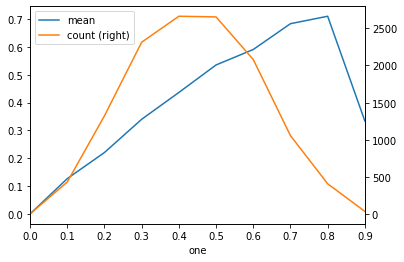

In [621]:
# df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3
# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.55
df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])
df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)
df_res_grouped = df_res_grouped.reset_index().set_index('one')

df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

In [622]:
df_res_grouped

,mean,count
one,,
0.0,0.000000,5
0.1,0.126728,434
0.2,0.220544,1324
0.3,0.339818,2313
0.4,0.436138,2662
0.5,0.534866,2653
0.6,0.590385,2080
0.7,0.683065,1057
0.8,0.709756,410


### Prediction

#### Categorical

In [474]:
eval_data.loc[:,'target'] = eval_labels
eval_data.loc[:,'target'] = eval_data.loc[:,'target'].shift(1)
eval_data.loc[:,'pred_class'] = model.predict(eval_data[train_cols])
eval_data.loc[:,'pred_class'] = eval_data.loc[:,'pred_class'].shift(1)

eval_data.loc[:,'pred_proba'] = model.predict_proba(eval_data[train_cols])[:,1]
eval_data.loc[:,'pred_proba'] = eval_data.loc[:,'pred_proba'].round(1)
eval_data.loc[:,'pred_proba'] = eval_data.loc[:,'pred_proba'].shift(1)

In [475]:
eval_data.groupby('target').mean()

,diff_HIGH_CLOSE,diff_OPEN_CLOSE,chng_CLOSE,chng_HIGH,foreign_stocks_mean,roll20min_diff_LOW_HIGH,diff_LOW_HIGH,roll2m_chng_HIGH,comp60d_maxVOL,roll20m_diff_HIGH_CLOSE,...,comp60d_minHIGH,roll3m_chng_OPEN1_CLOSE,roll10m_diff_LOW_HIGH,roll20max_chng_CLOSE,roll10max_diff_LOW_HIGH,roll5max_chng_VOL,comp20d_minOPEN,comp30d_maxOPEN,pred_class,pred_proba
target,,,,,,,,,,,,,,,,,,,,,
0.0,0.030037,0.007900,-0.287619,-0.064969,-0.445891,0.011906,0.052532,-0.081404,-75.184671,0.024646,...,29.448977,1.134012,0.049275,10.577710,0.098136,7981.649555,16.602945,-15.968478,0.172935,0.299963
1.0,0.024729,-0.000267,0.545629,0.230546,-0.036861,0.012779,0.052364,0.344426,-75.820030,0.026600,...,36.418745,0.451219,0.051294,11.438664,0.102807,8066.749966,18.493701,-16.985582,0.525437,0.503821


In [476]:
eval_data.groupby('pred_class').mean()

,diff_HIGH_CLOSE,diff_OPEN_CLOSE,chng_CLOSE,chng_HIGH,foreign_stocks_mean,roll20min_diff_LOW_HIGH,diff_LOW_HIGH,roll2m_chng_HIGH,comp60d_maxVOL,roll20m_diff_HIGH_CLOSE,...,comp60d_minHIGH,roll3m_chng_OPEN1_CLOSE,roll10m_diff_LOW_HIGH,roll20max_chng_CLOSE,roll10max_diff_LOW_HIGH,roll5max_chng_VOL,comp20d_minOPEN,comp30d_maxOPEN,target,pred_proba
pred_class,,,,,,,,,,,,,,,,,,,,,
0.0,0.029968,0.008705,-0.440403,-0.174889,-0.707173,0.011987,0.052474,0.045214,-75.320725,0.024854,...,34.019019,1.014821,0.049332,11.115010,0.098592,8330.679025,17.937808,-15.878134,0.262836,0.257133
1.0,0.023589,-0.004071,1.092313,0.549635,0.649969,0.012809,0.052455,0.163966,-75.669537,0.026609,...,27.854344,0.552247,0.051659,10.441885,0.102924,7303.458094,15.956708,-17.436895,0.653740,0.649812


In [477]:
eval_data.groupby('pred_proba').mean()

,diff_HIGH_CLOSE,diff_OPEN_CLOSE,chng_CLOSE,chng_HIGH,foreign_stocks_mean,roll20min_diff_LOW_HIGH,diff_LOW_HIGH,roll2m_chng_HIGH,comp60d_maxVOL,roll20m_diff_HIGH_CLOSE,...,comp60d_minHIGH,roll3m_chng_OPEN1_CLOSE,roll10m_diff_LOW_HIGH,roll20max_chng_CLOSE,roll10max_diff_LOW_HIGH,roll5max_chng_VOL,comp20d_minOPEN,comp30d_maxOPEN,target,pred_class
pred_proba,,,,,,,,,,,,,,,,,,,,,
0.0,0.039500,0.021725,-2.058128,-0.576908,-1.922818,0.010956,0.059461,-0.372029,-74.174274,0.023539,...,37.298930,1.693801,0.049186,12.337672,0.101619,9640.531712,20.116090,-16.035631,0.036923,0.000000
0.1,0.036391,0.016985,-1.463307,-0.725102,-1.331453,0.012463,0.057494,-0.209290,-74.302909,0.025662,...,35.304625,1.504091,0.051783,12.308328,0.102587,10309.837901,21.011433,-16.711778,0.105563,0.000000
0.2,0.032132,0.009507,-0.232489,-0.020240,-0.949022,0.012475,0.055569,-0.022385,-74.578000,0.026323,...,39.478965,1.381152,0.051491,11.981482,0.102439,8389.965129,18.273766,-17.118259,0.223445,0.000000
0.3,0.025664,0.003989,-0.123485,-0.133247,-0.401880,0.011593,0.049160,0.368252,-75.732776,0.023971,...,35.213089,0.605559,0.047309,10.791356,0.095786,5272.921797,18.178047,-15.115262,0.300744,0.000000
0.4,0.025260,0.003848,0.099720,0.077104,-0.148126,0.011754,0.047386,0.045888,-76.319889,0.024100,...,28.206137,0.683073,0.047221,9.982570,0.094596,9888.484815,14.572176,-15.059809,0.400922,0.000000
0.5,0.023856,0.000156,0.517711,0.409479,0.153140,0.011514,0.048509,0.304709,-77.094536,0.023638,...,23.647945,0.250984,0.046850,8.909183,0.093937,9884.620577,14.725575,-14.435608,0.486671,0.477371
0.6,0.022020,-0.001798,0.846808,0.437943,0.333862,0.011753,0.048004,0.130411,-76.441786,0.023936,...,27.532119,0.575231,0.047769,9.560808,0.095308,5286.248097,14.548854,-14.907410,0.609033,1.000000
0.7,0.023981,-0.002640,0.998192,0.388397,0.688910,0.012961,0.051286,0.135001,-76.204877,0.026446,...,25.177703,0.701021,0.050637,10.749184,0.101159,6422.144169,17.373203,-17.123404,0.716461,1.000000
0.8,0.025525,-0.008954,1.703248,0.753574,1.321915,0.015153,0.062300,-0.050309,-73.281330,0.032834,...,35.759908,0.803705,0.061984,13.008796,0.121341,5482.476108,18.650049,-22.831975,0.772487,1.000000


#### Prediction for couple of papers

In [331]:
# res_cols = ['DTYYYYMMDD','TICKER', 'OPEN', 'LOW', 'HIGH','CLOSE', 'target_OPEN_chng',
#             'target_HIGH_chng', 'target_CLOSE_chng', 'prob_newHIGH']

# res = pd.DataFrame(columns=res_cols)

In [478]:
res = pd.DataFrame()

In [479]:
for p in tqdm(skaner_df_see.ticker.values):
    
    df = prepare_data(p)
    df = transform_one_paper_ch(df)
    
    df = df.merge(df_indexes_merged, left_index=True, right_index=True, how = 'left')

    df.loc[:,'pred_class'] = model.predict(df[train_cols])
    df.loc[:,'pred_prob'] = model.predict_proba(df[train_cols])[:,1]
    
    df.loc[:,'fut_OPEN'] = df.loc[:,'OPEN'].shift(-1)
    df.loc[:,'target_OPEN_chng'] = (df.loc[:,'fut_OPEN'] * 100 / df.loc[:,'CLOSE']) - 100
    df.loc[:,'target_HIGH_chng'] = df.loc[:,'chng_HIGH'].shift(-1).copy()
    df.loc[:,'target_CLOSE_chng'] = df.loc[:,'chng_CLOSE'].shift(-1).copy()

    one_res = df.reset_index().loc[:,['DTYYYYMMDD','TICKER','OPEN','LOW','HIGH', 'CLOSE', 
                                      'target', 'pred_class', 'target_OPEN_chng',
                                      'target_HIGH_chng', 'target_CLOSE_chng', 'pred_prob']].tail(2)
    res = pd.concat([res, one_res])
#     res = pd.concat([res, pd.DataFrame([[one_res.DTYYYYMMDD.values[0], 
#                                    one_res.TICKER.values[0],
#                                    one_res.OPEN.values[0],
#                                    one_res.LOW.values[0],
#                                    one_res.HIGH.values[0],
#                                    one_res.CLOSE.values[0],
#                                    one_res.target_OPEN_chng.values[0],
#                                    one_res.target_HIGH_chng.values[0],
#                                    one_res.target_CLOSE_chng.values[0],
#                                    one_res.pred_prob.values[0]]], columns=res_cols)])

100%|██████████| 202/202 [02:16<00:00,  1.48it/s]


In [481]:
res = res.sort_values('pred_prob', ascending=False).drop(['pred_class','target_OPEN_chng', 'target'], axis = 1).head(100)

In [484]:
res.loc[res.DTYYYYMMDD == '2020-04-08']

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,target_HIGH_chng,target_CLOSE_chng,pred_prob
3710,2020-04-08,LOTOS,62.580,61.560,65.780,65.600,1.276984,-3.658537,0.896450
5572,2020-04-08,STALPROD,133.000,126.000,139.000,138.200,0.575540,0.868307,0.883124
5573,2020-04-08,WIG-TELKOM,749.210,744.090,797.820,795.290,4.087388,3.582341,0.842514
475,2020-04-08,TSGAMES,300.000,297.000,312.000,311.000,4.006410,-0.643087,0.834996
1054,2020-04-08,ENTER,18.000,17.400,18.900,18.900,8.465608,5.555556,0.828425
263,2020-04-08,WIG.GAMES,21037.970,21037.970,21981.810,21832.410,4.849191,3.320110,0.826168
3835,2020-04-08,NEUCA,431.500,425.000,437.500,437.500,1.485714,-0.114286,0.816587
2157,2020-04-08,VENTUREIN,1.690,1.350,1.900,1.900,26.315789,-5.789474,0.810074
2184,2020-04-08,JSW,12.590,12.300,12.935,12.860,2.744492,1.788491,0.809628
2982,2020-04-08,CYFRPLSAT,24.020,23.700,24.800,24.800,4.596774,4.032258,0.804316


In [335]:
df = df_merged.copy()

In [336]:
df.loc[:,'pred_class'] = model.predict(df[train_cols])
df.loc[:,'pred_prob'] = model.predict_proba(df[train_cols])[:,1]

df.loc[:,'fut_OPEN'] = df.loc[:,'OPEN'].shift(-1)
df.loc[:,'target_OPEN_chng'] = (df.loc[:,'fut_OPEN'] * 100 / df.loc[:,'CLOSE']) - 100
df.loc[:,'target_HIGH_chng'] = df.loc[:,'chng_HIGH'].shift(-1).copy()
df.loc[:,'target_CLOSE_chng'] = df.loc[:,'chng_CLOSE'].shift(-1).copy()

In [340]:
res = df.reset_index()

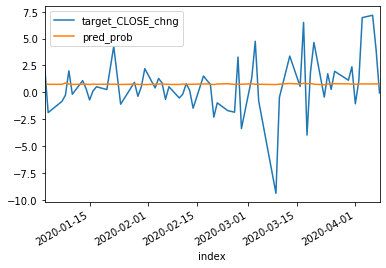

In [354]:
res.loc[(res.loc[:,'index'] > '2020-01-01')
        & (res.pred_prob > 0.7), :].groupby(['index']).mean()[['target_CLOSE_chng', 'pred_prob']].plot()

In [360]:
res.loc[(res.loc[:,'index'] > '2020-01-01')
        & (res.pred_prob > 0.8), :].groupby(['index']).mean()[
    ['target_HIGH_chng','target_CLOSE_chng', 'pred_prob']].median()

target_HIGH_chng     0.202429
target_CLOSE_chng    0.887612
pred_prob            0.833990
dtype: float64

In [355]:
res.sort_values('pred_prob', ascending=False).head(100)

,index,TICKER,OPEN,HIGH,LOW,CLOSE,VOL,OPEN_shifted,chng_OPEN,LOW_shifted,...,target,foreign_stocks_mean,foreign_stocks_max,foreign_stocks_min,pred_class,pred_prob,fut_OPEN,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng
199145,2011-08-11,PGE,17.85,19.250,17.6500,19.250,6.587300e+06,19.150,-6.788512,17.2400,...,1.0,2.857047,5.404341,-0.952958,1.0,0.967548,949.240,4831.116883,-6.512986,9.040890
541326,2020-03-19,WIG20LEV,228.15,248.410,221.7200,248.410,9.736780e+05,234.310,-2.628996,218.3100,...,1.0,1.330692,7.141789,-5.605968,1.0,0.960654,16.400,-93.398011,-4.576659,1.863354
541325,2020-03-19,PGE,3.65,4.036,3.6200,4.036,7.531181e+06,3.520,3.693182,3.3500,...,1.0,1.330692,7.141789,-5.605968,1.0,0.957879,228.150,5552.874133,0.327141,9.721731
199146,2011-08-11,WIG20LEV,949.24,1014.680,863.6800,1014.680,1.683095e+06,1071.960,-11.448188,878.6300,...,1.0,2.857047,5.404341,-0.952958,1.0,0.955207,84.500,-91.672251,-2.526316,4.360465
541313,2020-03-19,CCC,26.00,29.780,25.4000,29.600,2.128518e+06,26.840,-3.129657,24.3000,...,1.0,1.330692,7.141789,-5.605968,1.0,0.954583,3.000,-89.864865,-3.225806,-3.333333
540604,2020-03-13,LOTOS,42.04,45.900,39.8200,44.990,8.754780e+05,40.500,3.802469,39.0000,...,0.0,3.955261,13.908829,-6.080832,1.0,0.954446,1.870,-95.843521,-2.777778,-2.551020
202290,2011-09-15,CDPROJEKT,3.72,3.950,3.7200,3.950,8.404720e+05,3.650,1.917808,3.6200,...,1.0,1.349585,3.271462,-0.332003,1.0,0.952014,2.520,-36.202532,2.325581,4.761905
540955,2020-03-17,CIGAMES,0.41,0.436,0.4000,0.436,2.820567e+06,0.374,9.625668,0.3370,...,1.0,3.179108,13.518576,-3.209159,1.0,0.950566,10.000,2193.577982,-11.297071,0.200401
541403,2020-03-19,WIG30,1631.13,1712.070,1617.3100,1712.070,1.033160e+06,1635.080,-0.241578,1598.5800,...,1.0,1.330692,7.141789,-5.605968,1.0,0.949328,2977.070,73.887166,3.295832,5.038784
540924,2020-03-17,MABION,25.00,31.000,25.0000,31.000,9.760700e+04,20.000,25.000000,18.5000,...,1.0,3.179108,13.518576,-3.209159,1.0,0.947911,4.960,-84.000000,3.488372,6.024096


In [363]:
res.loc[res.pred_prob > 0.7].mean()

OPEN                    694.408521
HIGH                    706.094534
LOW                     691.763361
CLOSE                   705.061505
VOL                  479465.474154
                         ...      
pred_prob                 0.756463
fut_OPEN                361.378365
target_OPEN_chng       3284.682078
target_HIGH_chng          0.329685
target_CLOSE_chng         0.637524
Length: 276, dtype: float64

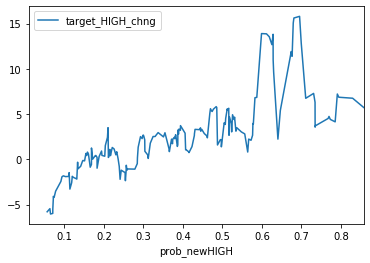

In [162]:
res.loc[:,['target_HIGH_chng', 'prob_newHIGH']]\
.sort_values('prob_newHIGH').set_index('prob_newHIGH').rolling(7).mean().plot()

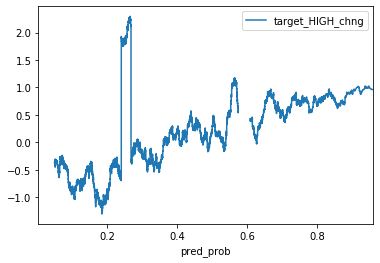

In [375]:
res.loc[res.loc[:,'index'] > '2020-01-01',['target_HIGH_chng', 'pred_prob']]\
.sort_values('pred_prob').set_index('pred_prob').rolling(500).mean().plot()

In [378]:
res.loc[res.loc[:,'index'] > '2020-04-07',:]

,index,TICKER,OPEN,HIGH,LOW,CLOSE,VOL,OPEN_shifted,chng_OPEN,LOW_shifted,...,target,foreign_stocks_mean,foreign_stocks_max,foreign_stocks_min,pred_class,pred_prob,fut_OPEN,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng
543985,2020-04-08,EFEKT,3.16,3.38,2.86,3.24,21180.0,2.58,22.480620,2.54,...,0.0,1.66631,5.106485,-1.166522,0.0,0.403466,25.70,693.209877,-9.507042,-7.692308
543986,2020-04-08,MABION,25.70,25.70,23.40,24.00,75002.0,28.40,-9.507042,25.65,...,0.0,1.66631,5.106485,-1.166522,0.0,0.242316,2.35,-90.208333,-1.673640,-10.638298
543987,2020-04-08,ELBUDOWA,2.35,2.35,1.91,2.10,129473.0,2.35,0.000000,2.18,...,0.0,1.66631,5.106485,-1.166522,0.0,0.113428,33.50,1495.238095,-10.053476,0.240964
543988,2020-04-08,CCC,33.50,33.64,31.50,33.28,521253.0,35.40,-5.367232,33.20,...,1.0,1.66631,5.106485,-1.166522,1.0,0.599440,2.94,-91.165865,-2.000000,-5.172414
543989,2020-04-08,SOLAR,2.94,2.94,2.65,2.75,10255.0,2.59,13.513514,2.48,...,0.0,1.66631,5.106485,-1.166522,0.0,0.181260,10.20,270.909091,-7.488987,-3.921569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544174,2020-04-08,EVEREST,7.20,7.20,7.00,7.20,1030.0,7.50,-4.000000,7.00,...,0.0,1.66631,5.106485,-1.166522,0.0,0.498369,8.00,11.111111,-0.934579,22.401848
544175,2020-04-08,PHARMENA,8.00,10.60,7.28,10.60,20106.0,10.50,-23.809524,8.52,...,1.0,1.66631,5.106485,-1.166522,1.0,0.701910,3.13,-70.471698,-24.074074,0.000000
544176,2020-04-08,BIOMEDLUB,3.13,4.10,2.64,3.40,9752784.0,5.10,-38.627451,3.33,...,1.0,1.66631,5.106485,-1.166522,1.0,0.529845,3.30,-2.941176,-13.157895,-5.120482
544177,2020-04-08,HARPER,3.30,3.30,2.97,3.15,164611.0,3.70,-10.810811,3.21,...,0.0,1.66631,5.106485,-1.166522,0.0,0.337076,0.27,-91.428571,-3.571429,-3.571429


#### Regression

In [103]:
df.loc[:, 'preds'] = model.predict(df[train_cols])

In [104]:
df.loc[:,['target', 'preds', 'OPEN', 'CLOSE']]

,target,preds,OPEN,CLOSE
DTYYYYMMDD,,,,
2017-07-27,0.027887,0.405700,36.00,35.50
2017-07-28,0.016772,0.115789,35.50,36.25
2017-07-31,0.012212,0.110641,36.37,36.80
2017-08-01,0.024067,0.119130,36.85,36.89
2017-08-02,0.013740,0.046849,36.98,36.50
...,...,...,...,...
2020-04-02,0.049110,0.034687,28.40,28.56
2020-04-03,0.036328,0.037045,28.10,29.48
2020-04-06,0.033443,0.032499,30.28,29.86


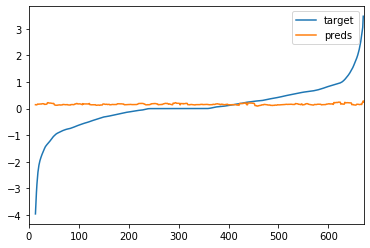

In [220]:
df.sort_values('target').reset_index()[['target', 'preds']].rolling(14).mean().plot()

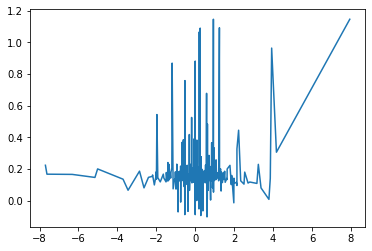

In [210]:
plt.plot(df.sort_values('target').target, df.sort_values('target').preds)

In [191]:
for c in ['preds', 'target']:
    df.loc[df.loc[:, c] > 0, c] = 1
    df.loc[df.loc[:, c] < 1, c] = 0

In [195]:
confusion_matrix(df.target[:-1].astype(int), df.preds[:-1].astype(int))

array([[  6, 351],
       [  6, 308]])

In [196]:
tn, fp, fn, tp = confusion_matrix(df.target[:-1].astype(int), df.preds[:-1].astype(int)).ravel()
(tn, fp, fn, tp)

(6, 351, 6, 308)

In [198]:
df.preds

DTYYYYMMDD
2017-07-27    1.0
2017-07-28    1.0
2017-07-31    1.0
2017-08-01    1.0
2017-08-02    1.0
             ... 
2020-04-02    1.0
2020-04-03    1.0
2020-04-06    1.0
2020-04-07    1.0
2020-04-08    0.0
Name: preds, Length: 672, dtype: float64

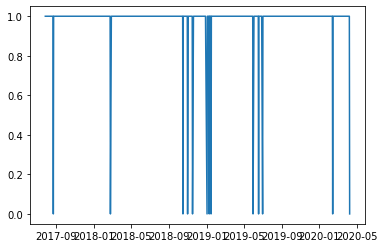

In [197]:
plt.plot(df.preds)

In [ ]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(2)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(2)

df_res_grouped = df_res.drop('zero', axis = 1)

df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3

# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.54

df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])

df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)

df_res_grouped = df_res_grouped.reset_index().set_index('one')

df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

df_res_grouped

## Foreign indexes

## Other

### Reports

In [42]:
all_reports = pd.read_csv('../bizcrap/fundamental_reports.csv')

In [61]:
cols_to_change = list(all_reports.columns)
cols_to_change[0] = 'Data'
all_reports.columns = cols_to_change

In [45]:
[a for a in all_reports.name.unique() if 'ORLEN' in a]

['raporty-PKN-ORLEN,Q.html']

In [55]:
cols_zysk = [c for c in all_reports.columns if 'zysk' in c]

In [53]:
for c in all_reports.columns:
    all_reports.loc[all_reports.loc[:,c]==-1,c] = np.nan

In [62]:
all_reports.head()

,Data,name,przychody_ze_sprzedaży_main,przychody_ze_sprzedaży_kk,przychody_ze_sprzedaży_sector,techniczny_koszt_wytworzenia_produkcji_sprzedanej_main,techniczny_koszt_wytworzenia_produkcji_sprzedanej_kk,techniczny_koszt_wytworzenia_produkcji_sprzedanej_sector,koszty_sprzedaży_main,koszty_sprzedaży_kk,...,odpisy_netto_z_tytułu_utraty_wartości_kredytów_sector,ogólne_koszty_administracyjne_main,ogólne_koszty_administracyjne_kk,ogólne_koszty_administracyjne_sector,wynik_operacyjny_main,wynik_operacyjny_kk,wynik_operacyjny_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
0,2011/Q1,"raporty-ROKITA,Q.html",282089.0,NaN,NaN,236690.0,NaN,NaN,16740.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/Q2,"raporty-ROKITA,Q.html",120180.0,-57.40,-6.11,104329.0,-55.92,-7.29,7965.0,-52.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011/Q3,"raporty-ROKITA,Q.html",186398.0,55.10,11.93,163713.0,56.92,4.74,10028.0,25.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011/Q4,"raporty-ROKITA,Q.html",232250.0,24.60,24.60,184412.0,12.64,12.64,17560.0,75.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012/Q1,"raporty-ROKITA,Q.html",243002.0,4.63,-7.39,202362.0,9.73,-4.46,13294.0,-24.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
all_reports.loc[all_reports.name=='raporty-PKN-ORLEN,Q.html',['Data', 'name'] + cols_zysk]

,Data,name,zysk_ze_sprzedaży_main,zysk_ze_sprzedaży_kk,zysk_ze_sprzedaży_sector,zysk_operacyjny_(ebit)_main,zysk_operacyjny_(ebit)_kk,zysk_operacyjny_(ebit)_sector,zysk_z_działalności_gospodarczej_main,zysk_z_działalności_gospodarczej_kk,...,zysk_(strata)_netto_z_działalności_zaniechanej_sector,zysk_netto_main,zysk_netto_kk,zysk_netto_sector,zysk_netto_akcjonariuszy_jednostki_dominującej_main,zysk_netto_akcjonariuszy_jednostki_dominującej_kk,zysk_netto_akcjonariuszy_jednostki_dominującej_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
6856,2005/Q1,"raporty-PKN-ORLEN,Q.html",783503.0,NaN,NaN,797953.0,NaN,NaN,820771.0,NaN,...,NaN,678534.0,NaN,NaN,667527.0,NaN,NaN,NaN,NaN,NaN
6857,2005/Q2,"raporty-PKN-ORLEN,Q.html",1101747.0,40.62,11.69,2615077.0,227.72,9.19,2813959.0,242.84,...,NaN,2565468.0,278.09,38.03,2560212.0,283.54,28.11,NaN,NaN,NaN
6858,2005/Q3,"raporty-PKN-ORLEN,Q.html",1120514.0,1.70,37.29,1090777.0,-58.29,29.90,1221227.0,-56.60,...,NaN,994419.0,-61.24,-0.90,985238.0,-61.52,-0.04,NaN,NaN,NaN
6859,2005/Q4,"raporty-PKN-ORLEN,Q.html",673032.0,-39.94,-24.82,443813.0,-59.31,-34.51,417113.0,-65.84,...,NaN,399355.0,-59.84,-1.46,365479.0,-62.90,-3.24,NaN,NaN,NaN
6860,2006/Q1,"raporty-PKN-ORLEN,Q.html",411141.0,-38.91,33.42,450747.0,1.56,39.40,476236.0,14.17,...,NaN,398153.0,-0.30,49.27,364977.0,-0.14,52.20,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,2019/Q1,"raporty-PKN-ORLEN,Q.html",968000.0,86.15,52.80,996000.0,-2.73,31.91,994000.0,2.16,...,NaN,849000.0,37.16,37.16,849000.0,28.25,28.25,NaN,NaN,NaN
6913,2019/Q2,"raporty-PKN-ORLEN,Q.html",1964000.0,102.89,20.46,2086000.0,109.44,52.52,2124000.0,113.68,...,NaN,1601000.0,88.57,62.23,1602000.0,88.69,56.36,NaN,NaN,NaN
6914,2019/Q3,"raporty-PKN-ORLEN,Q.html",1975000.0,0.56,1.69,1807000.0,-13.37,-13.37,1567000.0,-26.22,...,NaN,1266000.0,-20.92,-20.92,1266000.0,-20.97,-23.19,NaN,NaN,NaN
6915,2019/Q4,"raporty-PKN-ORLEN,Q.html",919000.0,-53.47,-16.94,673000.0,-62.76,-32.94,866000.0,-44.74,...,NaN,771000.0,-39.10,-19.55,772000.0,-39.02,-21.16,NaN,NaN,NaN
